In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)


In [4]:
df = pd.read_csv("../data/raw/pollution_history.csv")
print("Rows:", len(df))
df.head()

Rows: 2160


,timestamp,city,lat,lon,aqi,pm2_5,pm10,no2,so2,o3
0,2025-09-15 10:00:00,Delhi,28.651718,77.221939,2,13.37,27.19,1.26,1.14,85.63
1,2025-09-15 11:00:00,Delhi,28.651718,77.221939,2,13.35,26.70,2.16,1.25,83.20
2,2025-09-15 12:00:00,Delhi,28.651718,77.221939,2,13.21,26.35,3.44,1.36,79.84
3,2025-09-15 13:00:00,Delhi,28.651718,77.221939,2,13.99,28.20,7.68,1.71,66.85
4,2025-09-15 14:00:00,Delhi,28.651718,77.221939,2,15.83,32.13,12.26,2.23,50.81


In [5]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  2160 non-null   object 
 1   city       2160 non-null   object 
 2   lat        2160 non-null   float64
 3   lon        2160 non-null   float64
 4   aqi        2160 non-null   int64  
 5   pm2_5      2160 non-null   float64
 6   pm10       2160 non-null   float64
 7   no2        2160 non-null   float64
 8   so2        2160 non-null   float64
 9   o3         2160 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 168.9+ KB


,lat,lon,aqi,pm2_5,pm10,no2,so2,o3
count,2.160000e+03,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000
mean,2.865172e+01,77.221939,4.061574,80.970718,113.858056,13.793778,4.565264,75.667264
std,3.553536e-15,0.000000,1.023759,54.999359,65.713959,9.392513,3.658426,38.367434
min,2.865172e+01,77.221939,1.000000,8.950000,11.190000,0.570000,0.480000,6.120000
25%,2.865172e+01,77.221939,3.000000,39.832500,62.870000,6.137500,2.170000,46.867500
50%,2.865172e+01,77.221939,4.000000,70.250000,102.475000,12.370000,3.760000,66.735000
75%,2.865172e+01,77.221939,5.000000,105.717500,152.552500,19.562500,5.950000,97.697500
max,2.865172e+01,77.221939,5.000000,312.890000,350.040000,44.680000,45.860000,199.040000


In [6]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")


In [7]:
df["hour"] = df["timestamp"].dt.hour
df["weekday"] = df["timestamp"].dt.weekday

In [8]:
df.isnull().sum()


timestamp    0
city         0
lat          0
lon          0
aqi          0
pm2_5        0
pm10         0
no2          0
so2          0
o3           0
hour         0
weekday      0
dtype: int64

In [9]:
df["pm2_5_ma"] = df["pm2_5"].rolling(3).mean()
df["pm10_ma"] = df["pm10"].rolling(3).mean()

df = df.dropna()


In [10]:
df.to_csv("../data/processed/cleaned_history_data.csv", index=False)


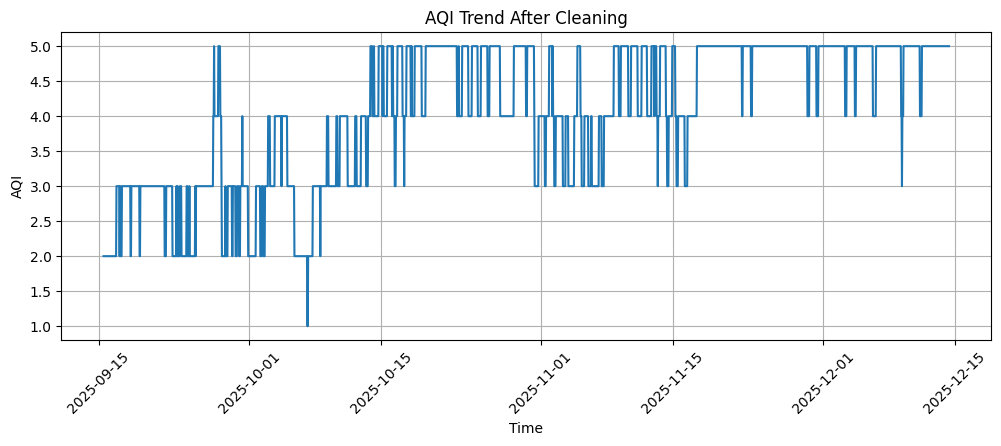

In [11]:
# AQI TREND OVER TIME

plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["aqi"])
plt.title("AQI Trend After Cleaning")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


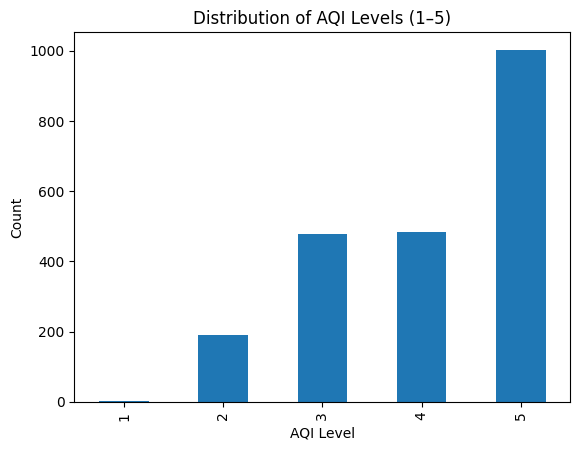

In [12]:
# AQI CATEGORY DISTRIBUTION

df["aqi"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution of AQI Levels (1–5)")
plt.xlabel("AQI Level")
plt.ylabel("Count")
plt.show()


POLLUTANT vs AQI

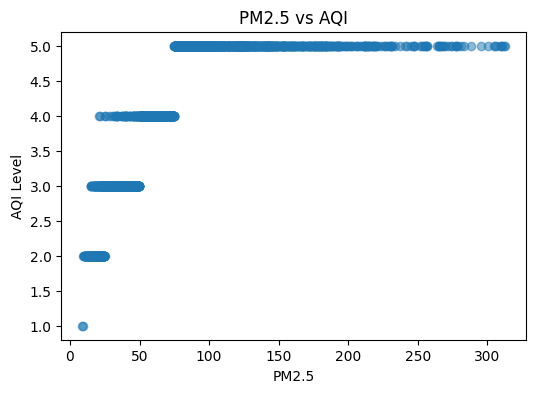

In [13]:
# PM2.5 vs AQI

plt.figure(figsize=(6,4))
plt.scatter(df["pm2_5"], df["aqi"], alpha=0.5)
plt.xlabel("PM2.5")
plt.ylabel("AQI Level")
plt.title("PM2.5 vs AQI")
plt.show()


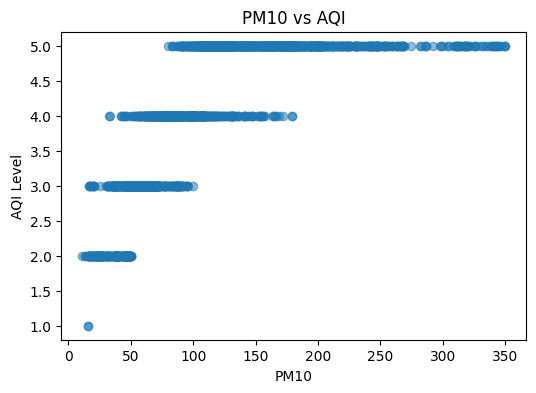

In [14]:
# PM10 vs AQI

plt.figure(figsize=(6,4))
plt.scatter(df["pm10"], df["aqi"], alpha=0.5)
plt.xlabel("PM10")
plt.ylabel("AQI Level")
plt.title("PM10 vs AQI")
plt.show()


HOURLY AQI PATTERN

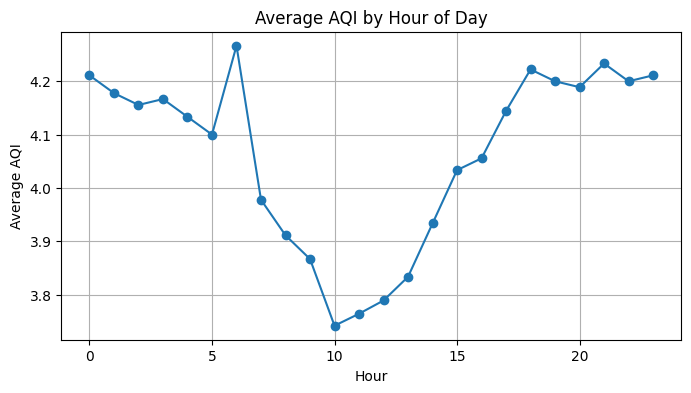

In [15]:
hourly_aqi = df.groupby("hour")["aqi"].mean()

plt.figure(figsize=(8,4))
hourly_aqi.plot(marker="o")
plt.title("Average AQI by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average AQI")
plt.grid(True)
plt.show()


CORRELATION HEATMAP

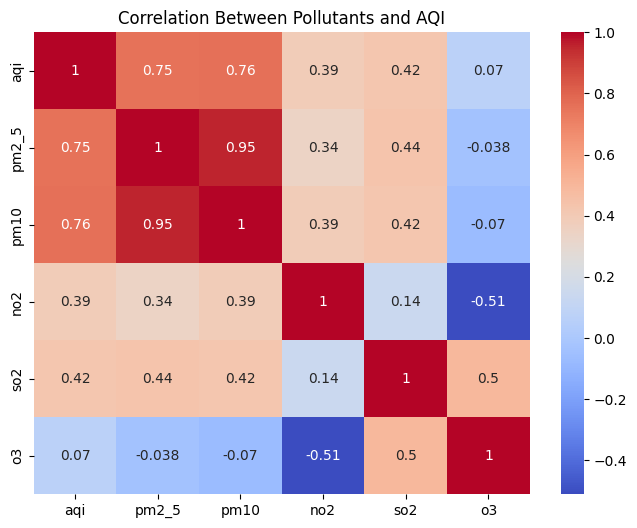

In [16]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(
    df[["aqi","pm2_5","pm10","no2","so2","o3"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation Between Pollutants and AQI")
plt.show()


RANDOM FOREST (BASELINE MODEL)

In [17]:
df["aqi_future_1h"] = df["aqi"].shift(-1)
df["aqi_future_3h"] = df["aqi"].shift(-3)
df["aqi_future_6h"] = df["aqi"].shift(-6)

df = df.dropna()


3 Hour Forecasting

In [68]:
from sklearn.model_selection import train_test_split

X = df[
    [
        "pm2_5", "pm10", "no2", "so2", "o3",
        "pm2_5_ma", "pm10_ma",
        "hour", "weekday"
    ]
]

y = df["aqi_future_3h"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [73]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(round(mae,4))
print(round(rmse,4))
print(round(r2,4))


0.0984
0.244
0.2839


1 Hour Forecasting

In [18]:
from sklearn.model_selection import train_test_split


X = df[
    [
        "pm2_5", "pm10", "no2", "so2", "o3",
        "pm2_5_ma", "pm10_ma",
        "hour", "weekday"
    ]
]

y = df["aqi_future_1h"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [19]:
y_train.name, y_test.name


('aqi_future_1h', 'aqi_future_1h')

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(round(mae,4))
print(round(rmse,4))
print(round(r2,4))

0.0513
0.1488
0.7335


In [21]:
import joblib
import os

os.makedirs("../models", exist_ok=True)
joblib.dump(rf, "../models/rf_aqi_1h.pkl")


['../models/rf_aqi_1h.pkl']

6 Hour Forecasting

In [76]:
X = df[
    [
        "pm2_5", "pm10", "no2", "so2", "o3",
        "pm2_5_ma", "pm10_ma",
        "hour", "weekday"
    ]
]

y = df["aqi_future_6h"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [77]:
pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(round(mae,4))
print(round(rmse,4))
print(round(r2,4))

0.1654
0.3636
-0.5908


In [22]:
importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance

pm2_5       0.906410
o3          0.027086
pm2_5_ma    0.019374
pm10        0.018164
hour        0.009221
so2         0.006371
no2         0.005878
pm10_ma     0.005360
weekday     0.002136
dtype: float64

In [23]:
predicted_aqi = rf.predict(X_test.iloc[-1:])[0]

def aqi_risk(aqi):
    if aqi <= 1.5:
        return "Good"
    elif aqi <= 2.5:
        return "Fair"
    elif aqi <= 3.5:
        return "Moderate"
    elif aqi <= 4.5:
        return "Poor"
    else:
        return "Very Poor"

risk = aqi_risk(predicted_aqi)

print("Predicted AQI (1h ahead):", round(predicted_aqi, 2))
print("Risk Level:", risk)


Predicted AQI (1h ahead): 5.0
Risk Level: Very Poor


LOAD LIVE DATA & PREPARE FEATURES

In [24]:
import pandas as pd
import joblib

# Load live pollution data
df_live = pd.read_csv("../data/raw/pollution_log.csv")

# Ensure timestamp is datetime
df_live["timestamp"] = pd.to_datetime(df_live["timestamp"])

# Sort just in case
df_live = df_live.sort_values("timestamp")

# Compute rolling features (same window used in training)
df_live["pm2_5_ma"] = df_live["pm2_5"].rolling(3).mean()
df_live["pm10_ma"] = df_live["pm10"].rolling(3).mean()

# Drop rows where rolling is NaN
df_live = df_live.dropna()

# Take latest row
latest = df_live.iloc[-1:].copy()

# Time features
latest["hour"] = latest["timestamp"].dt.hour
latest["weekday"] = latest["timestamp"].dt.weekday

# Feature set MUST MATCH training
X_live = latest[
    [
        "pm2_5", "pm10", "no2", "so2", "o3",
        "pm2_5_ma", "pm10_ma",
        "hour", "weekday"
    ]
]

X_live


,pm2_5,pm10,no2,so2,o3,pm2_5_ma,pm10_ma,hour,weekday
133,134.06,182.54,12.3,7.72,111.97,159.02,212.56,16,1


LOAD MODEL & MAKE LIVE PREDICTION

In [25]:
# Load trained model
rf_live = joblib.load("../models/rf_aqi_1h.pkl")

# Predict AQI 1 hour ahead
predicted_aqi = rf_live.predict(X_live)[0]
predicted_aqi


np.float64(4.993333333333333)

CONVERT TO HEALTH RISK (DEPLOYMENT LOGIC)

In [26]:
risk = aqi_risk(predicted_aqi)

print("Predicted AQI (1h ahead):", round(predicted_aqi, 2))
print("Risk Level:", risk)


Predicted AQI (1h ahead): 4.99
Risk Level: Very Poor


In [28]:
len_before = len(df_live)
len_before


132

After ~1 hour

In [44]:
df_live_after = pd.read_csv("../data/raw/pollution_log.csv")

actual_aqi = df_live_after.iloc[len_before + 3]["aqi"]
absolute_error = abs(actual_aqi - predicted_aqi)

print("Predicted AQI (1h ahead):", predicted_aqi)
print("Actual AQI (after ~1h):", actual_aqi)
print("Absolute Error:", absolute_error)


Predicted AQI (1h ahead): 5.0
Actual AQI (after ~1h): 5
Absolute Error: 0.0


Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize model
lr = LinearRegression()

# Train
lr.fit(X_train, y_train)

# Predict
lr_pred = lr.predict(X_test)

# Evaluate
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print("Linear Regression Results")
print("MAE :", round(lr_mae, 4))
print("RMSE:", round(lr_rmse, 4))
print("R2  :", round(lr_r2, 4))

Linear Regression Results
MAE : 0.8191
RMSE: 1.1634
R2  : -15.2845


Gradient Boosting Regressor

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize model
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# Train
gbr.fit(X_train, y_train)

# Predict
gbr_pred = gbr.predict(X_test)

# Evaluate
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_pred))
gbr_r2 = r2_score(y_test, gbr_pred)

print("Gradient Boosting Results")
print("MAE :", round(gbr_mae, 4))
print("RMSE:", round(gbr_rmse, 4))
print("R2  :", round(gbr_r2, 4))

Gradient Boosting Results
MAE : 0.0698
RMSE: 0.1515
R2  : 0.7239


In [31]:
import joblib
import os

# Create models directory if not exists
os.makedirs("../models", exist_ok=True)

# Save Gradient Boosting model
joblib.dump(gbr, "../models/gb_aqi_1h.pkl")

print("Gradient Boosting model saved successfully.")


Gradient Boosting model saved successfully.


In [32]:
import pandas as pd

# Load live logged data
df_live = pd.read_csv("../data/raw/pollution_log.csv")

# Convert timestamp
df_live["timestamp"] = pd.to_datetime(df_live["timestamp"])

# Sort to ensure correct order
df_live = df_live.sort_values("timestamp")

# Rolling features (same as training)
df_live["pm2_5_ma"] = df_live["pm2_5"].rolling(3).mean()
df_live["pm10_ma"] = df_live["pm10"].rolling(3).mean()

# Drop rows with NaN rolling values
df_live = df_live.dropna()

# Take latest row
latest = df_live.iloc[-1:].copy()

# Time features
latest["hour"] = latest["timestamp"].dt.hour
latest["weekday"] = latest["timestamp"].dt.weekday

# Feature matrix (EXACT same columns & order as training)
X_live = latest[
    [
        "pm2_5", "pm10", "no2", "so2", "o3",
        "pm2_5_ma", "pm10_ma",
        "hour", "weekday"
    ]
]

X_live


,pm2_5,pm10,no2,so2,o3,pm2_5_ma,pm10_ma,hour,weekday
135,141.53,191.13,21.5,6.74,90.04,139.04,188.266667,17,1


In [33]:
import joblib

# Load Gradient Boosting model
gb_live = joblib.load("../models/gb_aqi_1h.pkl")

# Predict AQI 1 hour ahead
predicted_aqi = gb_live.predict(X_live)[0]

print("Predicted AQI (1 hour ahead):", round(predicted_aqi, 2))


Predicted AQI (1 hour ahead): 5.02


In [34]:
def aqi_risk(aqi):
    if aqi <= 1.5:
        return "Good"
    elif aqi <= 2.5:
        return "Fair"
    elif aqi <= 3.5:
        return "Moderate"
    elif aqi <= 4.5:
        return "Poor"
    else:
        return "Very Poor"

risk_level = aqi_risk(predicted_aqi)

print("Health Risk Level:", risk_level)


Health Risk Level: Very Poor


In [ ]:
df_after = pd.read_csv("../data/raw/pollution_log.csv")

actual_aqi = df_after.iloc[-1]["aqi"]
absolute_error = abs(actual_aqi - predicted_aqi)

print("Actual AQI after ~1 hour:", actual_aqi)
print("Predicted AQI:", round(predicted_aqi, 2))
print("Absolute Error:", round(absolute_error, 3))
